In [15]:
import pandas as pd # manipulação de dados em formato de dataframe
import numpy as np # operações matemáticas
import seaborn as sns # visualização gráfica
import matplotlib.pyplot as plt # visualização gráfica
import statsmodels.api as sm # estimação de modelos
from pymer4.models import Lmer # estimação de modelos HLM3 neste código
from scipy import stats # estatística chi2
from statsmodels.iolib.summary2 import summary_col # comparação entre modelos
from scipy.stats import gaussian_kde # inserção de KDEs em gráficos
from matplotlib.gridspec import GridSpec # plotagem de gráficos separados
import time # definição do intervalo de tempo entre gráficos com animação
# import imageio # para geração de figura GIF
from tqdm import tqdm # adiciona um indicador de progresso do código

#### ESTIMAÇÃO DE MODELOS HIERÁRQUICOS LINEARES DE DOIS NÍVEIS COM DADOS AGRUPADOS       

In [16]:
# Carregamento da base de dados 'desempenho_aluno_escola'
df_aluno_escola = pd.read_csv('data/desempenho_aluno_escola.csv', delimiter=',')

# Visualização da base de dados 'desempenho_aluno_escola'
df_aluno_escola

# Atribuição de categorias para as variáveis 'estudante' e 'escola'
df_aluno_escola['estudante'] = df_aluno_escola['estudante'].astype('category')
df_aluno_escola['escola'] = df_aluno_escola['escola'].astype('category')

# Características das variáveis do dataset
df_aluno_escola.info()

# Estatísticas univariadas
df_aluno_escola.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 358 entries, 0 to 357
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   estudante   358 non-null    category
 1   escola      358 non-null    category
 2   desempenho  358 non-null    float64 
 3   horas       358 non-null    int64   
 4   texp        358 non-null    float64 
dtypes: category(2), float64(2), int64(1)
memory usage: 20.8 KB


,desempenho,horas,texp
count,358.000000,358.000000,358.000000
mean,41.554190,18.997207,5.161173
std,23.225896,6.368910,3.682676
min,6.500000,4.000000,1.900000
25%,21.000000,14.000000,1.900000
50%,35.500000,20.000000,3.600000
75%,59.000000,24.000000,7.500000
max,100.000000,31.000000,13.000000


In [17]:
# Estudo sobre o desbalanceamento dos dados por escola

df_aluno_escola.groupby('escola')['estudante'].count().reset_index()

C:\Users\guilh\AppData\Local\Temp\ipykernel_14576\647930596.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_aluno_escola.groupby('escola')['estudante'].count().reset_index()


,escola,estudante
0,1,47
1,2,25
2,3,48
3,4,20
4,5,48
5,6,30
6,7,28
7,8,35
8,9,44
9,10,33


In [18]:
# Desempenho médio dos estudantes por escola

desempenho_medio = df_aluno_escola.groupby('escola')['desempenho'].mean().reset_index()
desempenho_medio

C:\Users\guilh\AppData\Local\Temp\ipykernel_14576\1050914325.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  desempenho_medio = df_aluno_escola.groupby('escola')['desempenho'].mean().reset_index()


,escola,desempenho
0,1,36.765957
1,2,21.400000
2,3,67.125000
3,4,55.325000
4,5,19.270833
5,6,33.966667
6,7,57.532143
7,8,75.428571
8,9,18.556818
9,10,38.590909


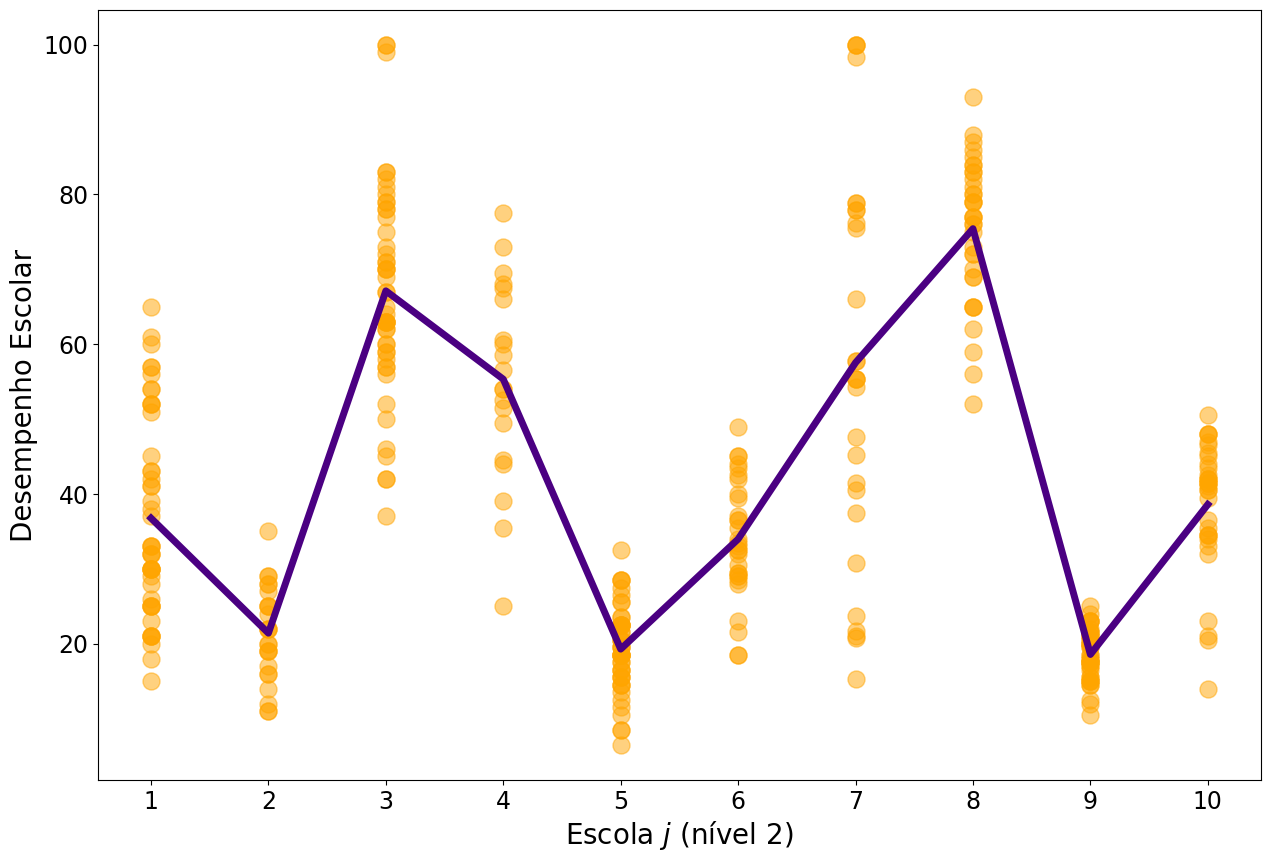

In [19]:
# Gráfico do desempenho escolar médio dos estudantes por escola

plt.figure(figsize=(15,10))
plt.plot(desempenho_medio['escola'], desempenho_medio['desempenho'],
         linewidth=5, color='indigo')
plt.scatter(df_aluno_escola['escola'], df_aluno_escola['desempenho'],
            alpha=0.5, color='orange', s = 150)
plt.xlabel('Escola $j$ (nível 2)', fontsize=20)
plt.ylabel('Desempenho Escolar', fontsize=20)
plt.xticks(desempenho_medio.escola, fontsize=17)
plt.yticks(fontsize=17)
plt.show()

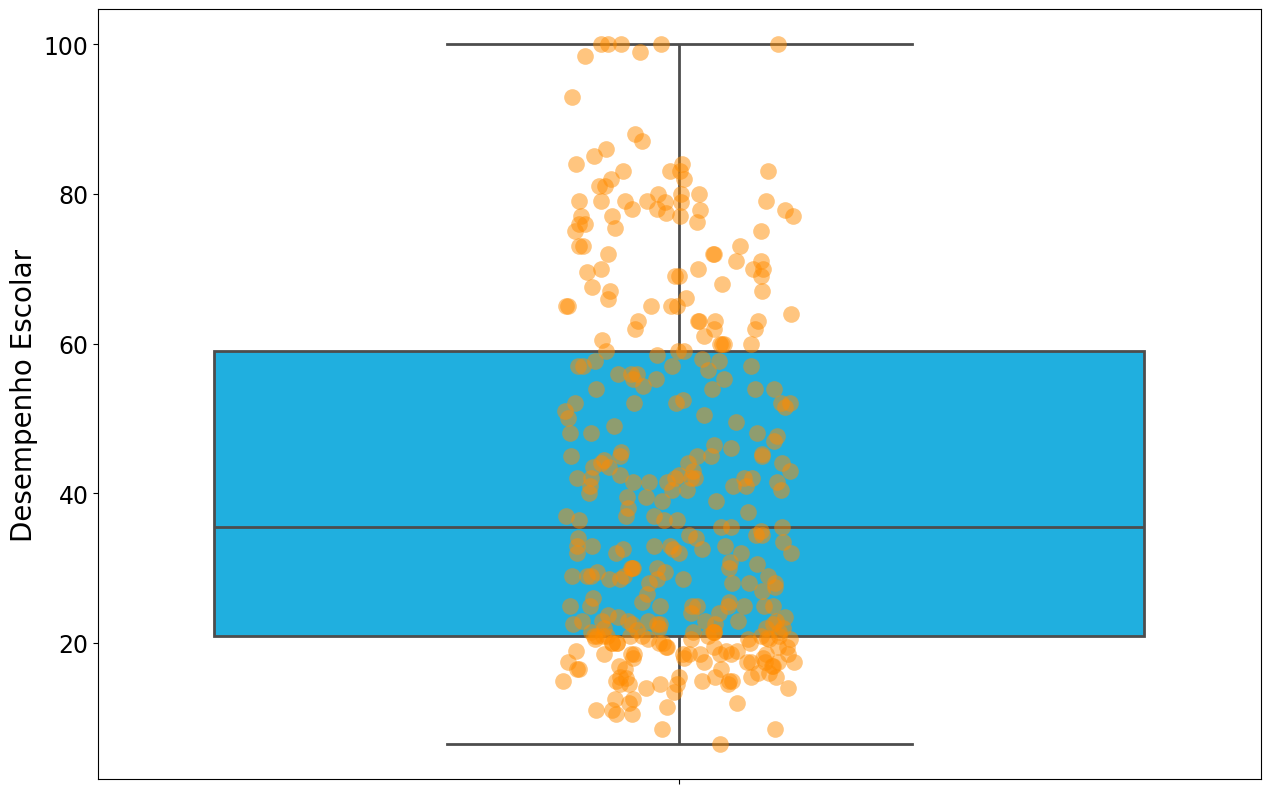

In [20]:
# Boxplot da variável dependente ('desempenho')

plt.figure(figsize=(15,10))
sns.boxplot(data=df_aluno_escola, y='desempenho',
            linewidth=2, orient='v', color='deepskyblue')
sns.stripplot(data=df_aluno_escola, y='desempenho',
              color='darkorange', jitter=0.1, size=12, alpha=0.5)
plt.ylabel('Desempenho Escolar', fontsize=20)
plt.yticks(fontsize=17)
plt.show()

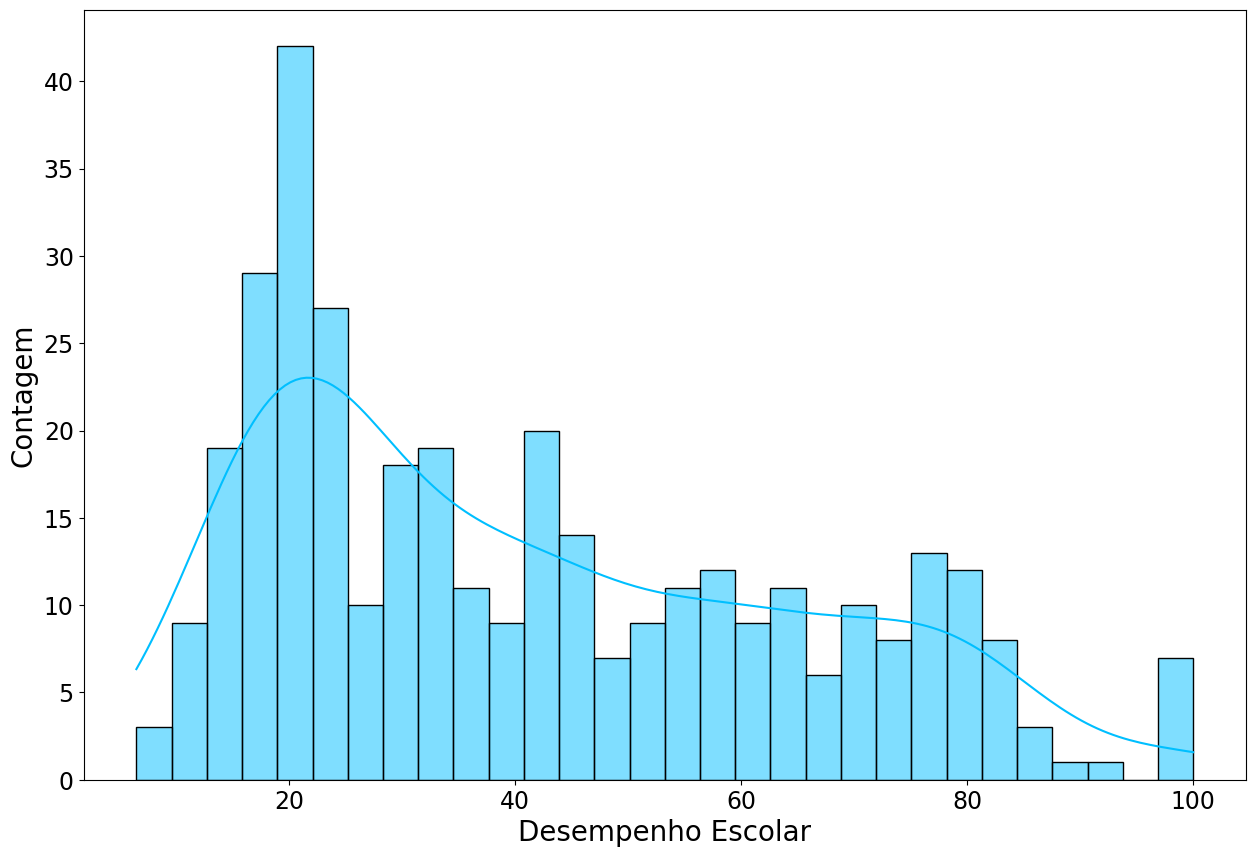

In [21]:
# Kernel density estimation (KDE) - função densidade de probabilidade
# da variável dependente ('desempenho'), com histograma

plt.figure(figsize=(15,10))
sns.histplot(data=df_aluno_escola['desempenho'], kde=True,
             bins=30, color='deepskyblue')
plt.xlabel('Desempenho Escolar', fontsize=20)
plt.ylabel('Contagem', fontsize=20)
plt.tick_params(axis='y', labelsize=17)
plt.tick_params(axis='x', labelsize=17)
plt.show()

C:\Users\guilh\AppData\Local\Temp\ipykernel_14576\902280217.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_aluno_escola, x='escola', y='desempenho',
C:\Users\guilh\AppData\Local\Temp\ipykernel_14576\902280217.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(data=df_aluno_escola, x='escola', y='desempenho',


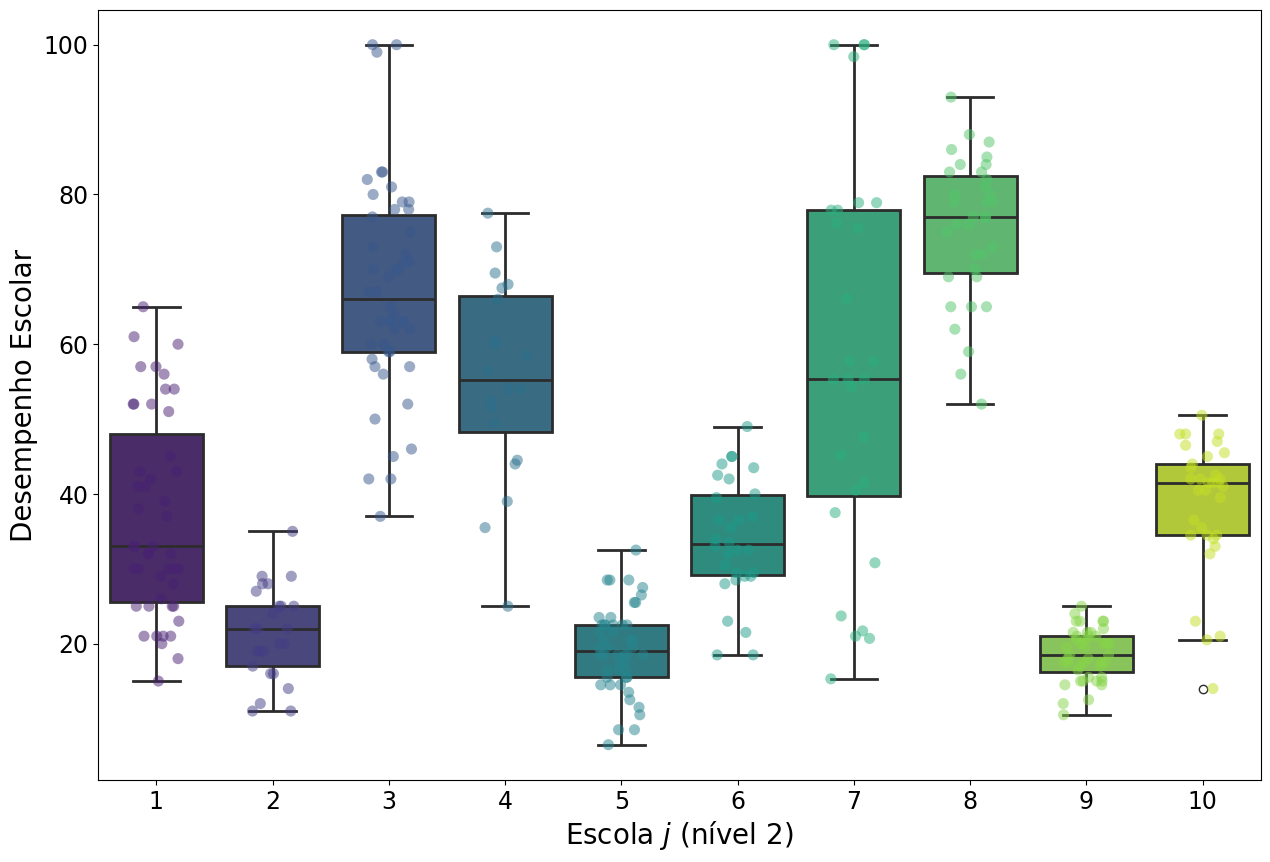

In [22]:
# Boxplot da variável dependente ('desempenho') por escola

plt.figure(figsize=(15,10))
sns.boxplot(data=df_aluno_escola, x='escola', y='desempenho',
            linewidth=2, orient='v', palette='viridis')
sns.stripplot(data=df_aluno_escola, x='escola', y='desempenho',
              palette='viridis', jitter=0.2, size=8, alpha=0.5)
plt.ylabel('Desempenho Escolar', fontsize=20)
plt.xlabel('Escola $j$ (nível 2)', fontsize=20)
plt.tick_params(axis='y', labelsize=17)
plt.tick_params(axis='x', labelsize=17)
plt.show()

<Figure size 1500x1000 with 0 Axes>

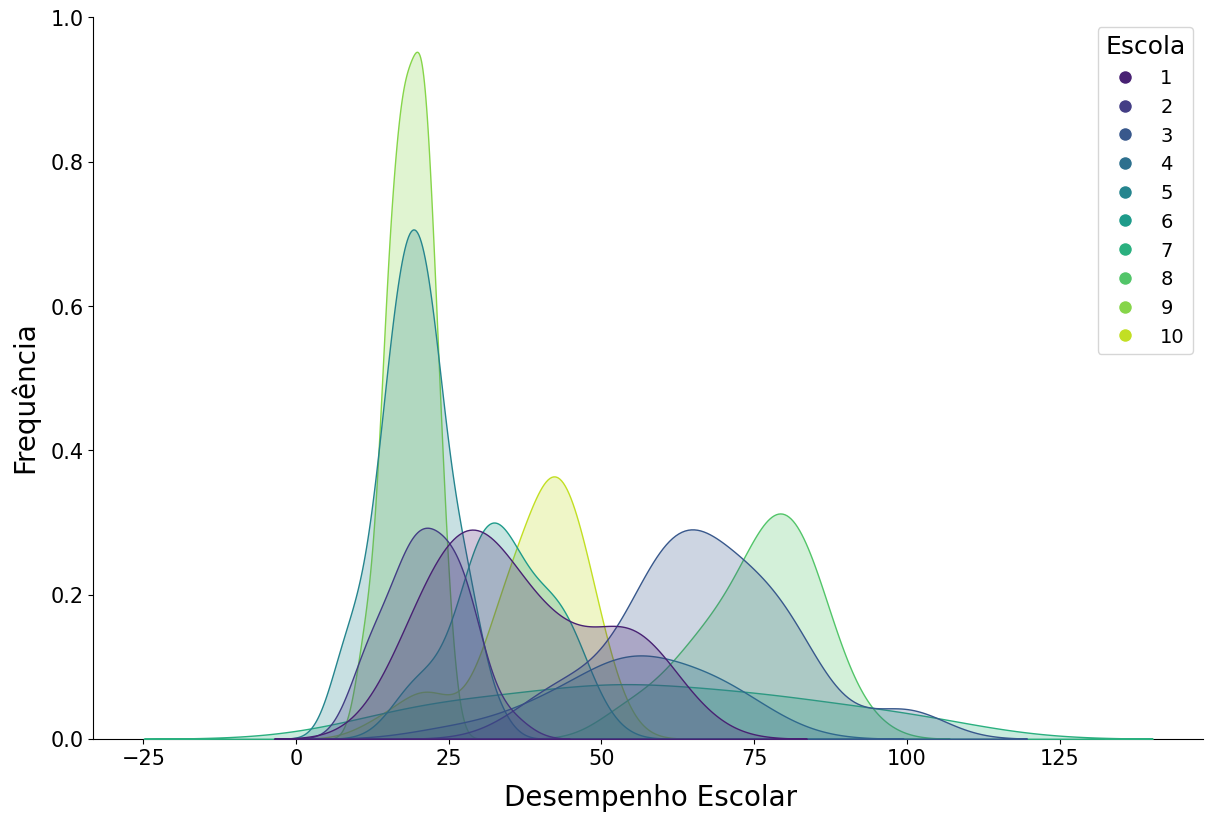

In [23]:
# Kernel density estimation (KDE) - função densidade de probabilidade
# da variável dependente ('desempenho') por escola

escolas = df_aluno_escola['escola'].unique()
colors = sns.color_palette('viridis', len(escolas))

plt.figure(figsize=(15, 10))
g = sns.pairplot(df_aluno_escola[['escola', 'desempenho']], hue='escola',
                 height=8,
                 aspect=1.5, palette=colors)
g._legend.remove()
g.set(xlabel=None)
g.set(ylabel=None)
g.tick_params(axis='both', which='major', labelsize=15)

# Gera a legenda com cores e rótulos das escolas
legend_elements = [plt.Line2D([0], [0], marker='o', color='w',
                              markerfacecolor=color,
                              markersize=10, label=escola)
                   for escola, color in zip(escolas, colors)]
plt.legend(handles=legend_elements, title='Escola', fontsize=14,
           title_fontsize=18)

# Adiciona os rótulos diretamente na figura
plt.gcf().text(0.5, -0.01, 'Desempenho Escolar', ha='center', fontsize=20)
plt.gcf().text(-0.01, 0.5, 'Frequência', va='center', rotation='vertical',
               fontsize=20)
plt.show()

KeyboardInterrupt: 

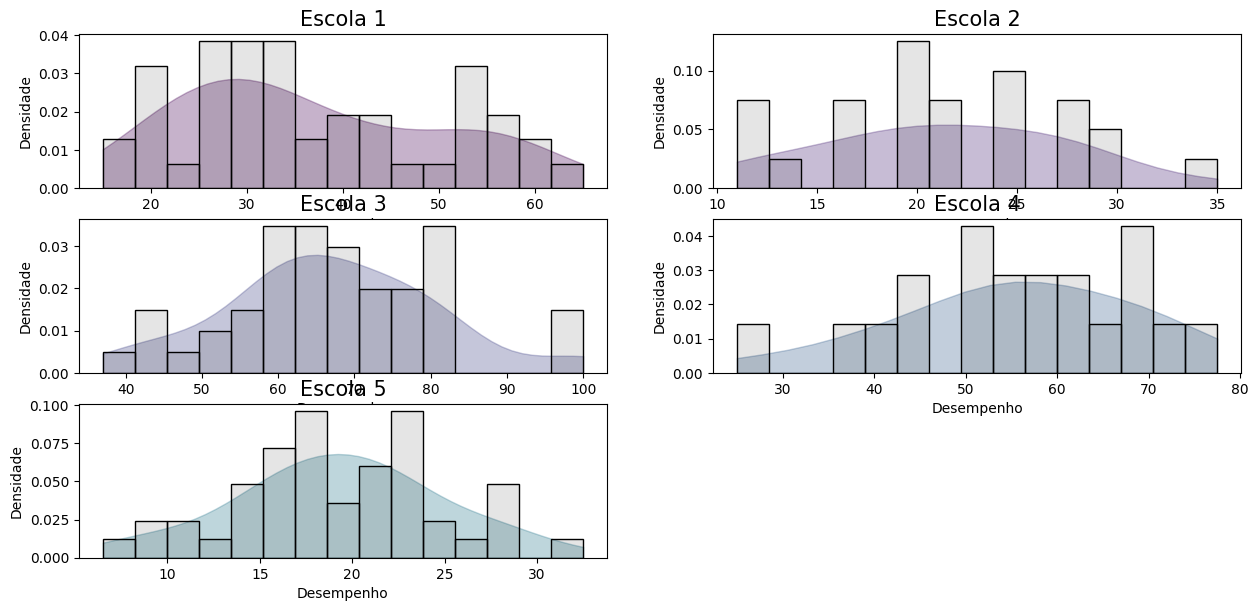

In [24]:
# Kernel density estimation (KDE) - função densidade de probabilidade
# da variável dependente ('desempenho'), com histograma e por escola separadamente
# (função 'GridSpec' do pacote 'matplotlib.gridspec')

escolas = df_aluno_escola['escola'].unique()

fig = plt.figure(figsize=(15, 14))
gs = GridSpec(len(escolas) // 2 + 1, 2, figure=fig)

for i, escola in enumerate(escolas):
    ax = fig.add_subplot(gs[i])

    # Subset dos dados por escola
    df_escola = df_aluno_escola[df_aluno_escola['escola'] == escola]

    # Densidade dos dados
    densidade = gaussian_kde(df_escola['desempenho'])
    x_vals = np.linspace(min(df_escola['desempenho']),
                         max(df_escola['desempenho']), len(df_escola))
    y_vals = densidade(x_vals)

    # Plotagem da density area
    ax.fill_between(x_vals, y_vals,
                    color=sns.color_palette('viridis',
                                            as_cmap=True)(i/len(escolas)),
                    alpha=0.3)
    
    # Adiciona o histograma
    sns.histplot(df_escola['desempenho'], ax=ax, stat="density", color="black",
                 edgecolor="black", fill=True, 
                 bins=15, alpha=0.1)
    ax.set_title(f'Escola {escola}', fontsize=15)
    ax.set_ylabel('Densidade')
    ax.set_xlabel('Desempenho')

plt.tight_layout()
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

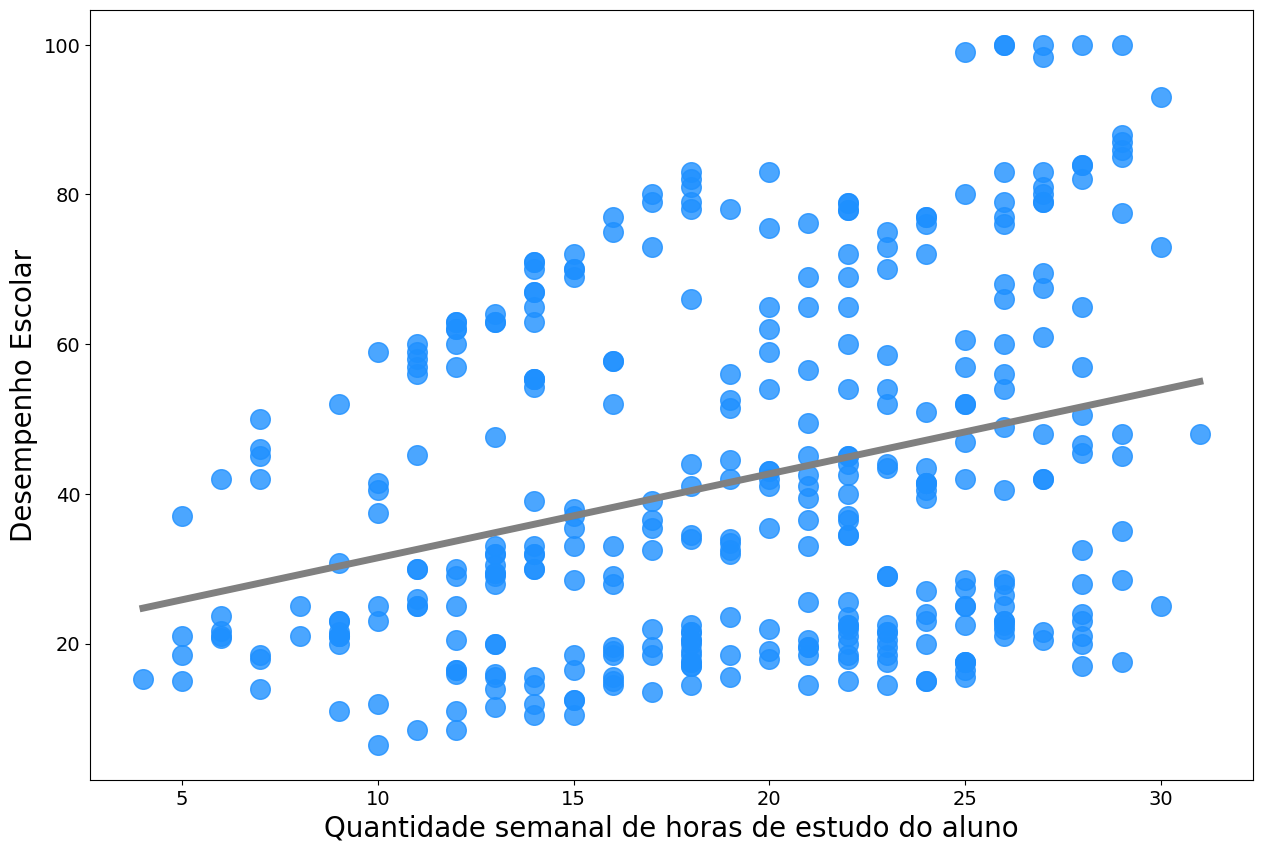

In [13]:
# Gráfico de desempenho x horas (OLS)

plt.figure(figsize=(15,10))
sns.regplot(data=df_aluno_escola, x='horas', y='desempenho', marker='o', ci=False,
            scatter_kws={"color":'dodgerblue', 'alpha':0.8, 's':200},
            line_kws={"color":'grey', 'linewidth': 5})
plt.xlabel('Quantidade semanal de horas de estudo do aluno', fontsize=20)
plt.ylabel('Desempenho Escolar', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show

In [ ]:
# Gráfico de desempenho x horas (OLS) por escola separadamente
# Animação no ambiente Plots

# Obtenção da lista de escolas
escolas = df_aluno_escola['escola'].unique()

# Definição do número de cores na paleta viridis
num_cores = len(escolas)

# Criação do dicionário de mapeamento da escola -> cor
cor_escola = dict(zip(escolas, sns.color_palette('viridis', num_cores)))

while True:
    # Loop para cada escola
    for escola in escolas:
        # Filtro dos dados para determinada escola
        data = df_aluno_escola[df_aluno_escola['escola'] == escola]

        # Criação do lmplot com a cor específica
        sns.lmplot(x='horas', y='desempenho', data=data, hue='escola',
                   height=6, aspect=1.5, ci=False, palette=[cor_escola[escola]])
        plt.title(f"Desempenho Escolar - Escola {escola}", fontsize=20)
        plt.xlabel("Quantidade Semanal de Horas de Estudo do Aluno", fontsize = 20)
        plt.ylabel("Desempenho Escolar", fontsize=20)
        plt.yticks(np.arange(0, 101, 20), fontsize=14)
        plt.xticks(np.arange(0, 36, 5), fontsize=14)
        plt.tight_layout()

        # Plotagem da figura
        plt.show()

        # Intervalo de tempo entre os gráficos
        time.sleep(1)

Gerando gráficos:   0%|          | 0/10 [00:00<?, ?escola/s]C:\Users\guilh\AppData\Local\Temp\ipykernel_14576\214877699.py:34: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed in 3.10. Use buffer_rgba instead.
  image = np.frombuffer(plt_canvas.tostring_rgb(), dtype='uint8')
Gerando gráficos:  10%|█         | 1/10 [00:00<00:03,  2.47escola/s]C:\Users\guilh\AppData\Local\Temp\ipykernel_14576\214877699.py:34: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed in 3.10. Use buffer_rgba instead.
  image = np.frombuffer(plt_canvas.tostring_rgb(), dtype='uint8')
Gerando gráficos:  20%|██        | 2/10 [00:00<00:03,  2.53escola/s]C:\Users\guilh\AppData\Local\Temp\ipykernel_14576\214877699.py:34: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed in 3.10. Use buffer_rgba instead.
  image = np.frombuffer(plt_canvas.tostrin

<Figure size 967.625x600 with 0 Axes>

<Figure size 967.625x600 with 0 Axes>

<Figure size 967.625x600 with 0 Axes>

<Figure size 967.625x600 with 0 Axes>

<Figure size 967.625x600 with 0 Axes>

<Figure size 967.625x600 with 0 Axes>

<Figure size 967.625x600 with 0 Axes>

<Figure size 967.625x600 with 0 Axes>

<Figure size 967.625x600 with 0 Axes>

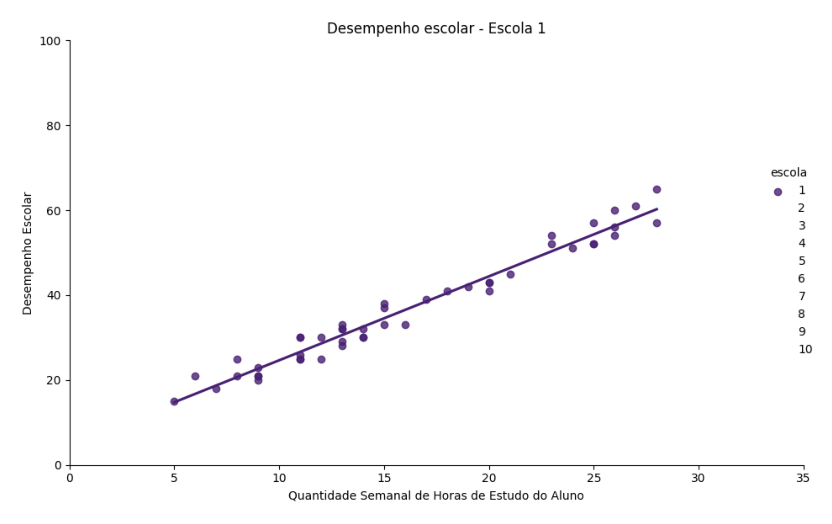

In [28]:
# Gráfico de desempenho x horas (OLS) por escola separadamente
# Geração de uma Figura GIF

# Obtenção da lista de escolas
escolas = df_aluno_escola['escola'].unique()

# Definição do número de cores na paleta viridis
num_cores = len(escolas)

# Criação do dicionário de mapeamento da escola -> cor
cor_escola = dict(zip(escolas, sns.color_palette('viridis', num_cores)))

# Lista para armazenar os frames dos gráficos
frames = []

# Loop para cada escola com 'tqdm' para mostrar o progresso
for escola in tqdm(escolas, desc="Gerando gráficos", unit="escola"):
    # Filtro dos dados para determinada escola
    data = df_aluno_escola[df_aluno_escola['escola'] == escola]

    # Criação do lmplot com a cor específica
    sns.lmplot(x='horas', y='desempenho', data=data, hue='escola',
               height=6, aspect=1.5, ci=False, palette=[cor_escola[escola]])
    plt.title(f"Desempenho escolar - Escola {escola}")
    plt.xlabel("Quantidade Semanal de Horas de Estudo do Aluno")
    plt.ylabel("Desempenho Escolar")
    plt.yticks(np.arange(0, 101, 20))
    plt.xticks(np.arange(0, 36, 5))
    plt.tight_layout()
    
    # Converte o gráfico em um array de imagens
    plt_canvas = plt.get_current_fig_manager().canvas
    plt_canvas.draw()
    image = np.frombuffer(plt_canvas.tostring_rgb(), dtype='uint8')
    image = image.reshape(plt_canvas.get_width_height()[::-1] + (3,))

    # Anexa o array de imagens à lista de quadros (frames)
    frames.append(image)

    # Limpa o gráfico para a próxima iteração
    plt.clf()

# Salva os quadros (frames) como um GIF
# imageio.mimsave('graficos_escolas.gif', frames, fps=1)

# Mostra o GIF
plt.imshow(frames[0])
plt.axis('off')
plt.show()

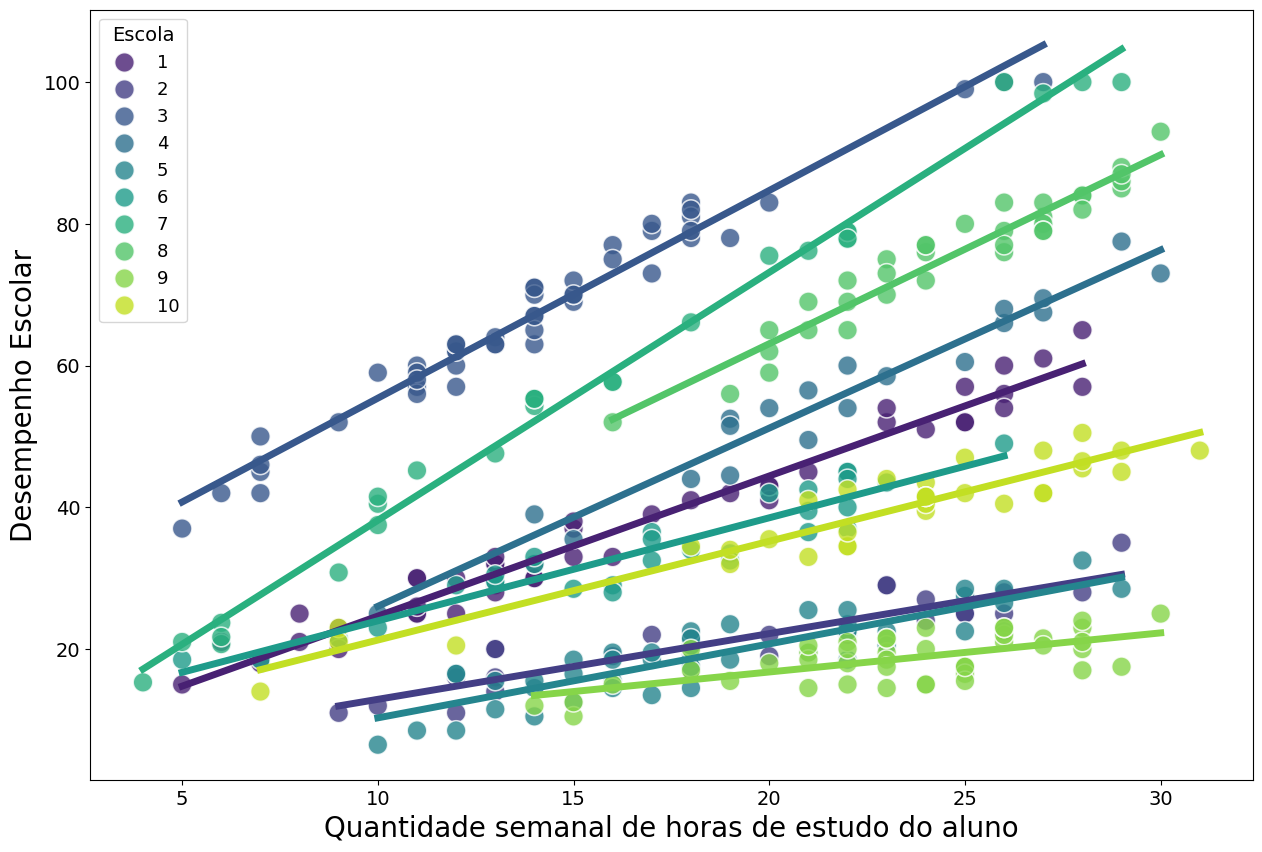

In [26]:
# Gráfico de desempenho escolar em função da variável 'horas'
# Variação entre estudantes de uma mesma escola e entre escolas diferentes
# Visualização do contexto!
# NOTE QUE A PERSPECTIVA MULTINÍVEL NATURALMENTE CONSIDERA O COMPORTAMENTO
#HETEROCEDÁSTICO NOS DADOS!

palette = sns.color_palette('viridis',
                            len(df_aluno_escola['escola'].unique()))

plt.figure(figsize=(15,10))
sns.scatterplot(data=df_aluno_escola, x='horas', y='desempenho', hue='escola',
                palette=palette, s=200, alpha=0.8, edgecolor='w')

for escola in df_aluno_escola['escola'].cat.categories:
    subset = df_aluno_escola[df_aluno_escola['escola'] == escola]
    sns.regplot(data=subset, x='horas', y='desempenho', scatter=False, ci=False,
                line_kws={"color": palette[df_aluno_escola['escola'].cat.categories.get_loc(escola)], 'linewidth': 5})

plt.xlabel('Quantidade semanal de horas de estudo do aluno', fontsize=20)
plt.ylabel('Desempenho Escolar', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(title='Escola', title_fontsize='14', fontsize='13', loc='upper left')
plt.show()